# Custom snake environment: Definitive Version

## We'll check for walls, apples and snake parts in 8 directions (24 inputs in total). The proximity is expressed as 1.0/distance. This way the sensor values range from 0 (if it is not in sight) to 1 if it is just in the next cell.  Additionally, the snake can smell the apple (south, north, west and east) and it knows the snake's moving direction
### If an experience has a reward different from zero it is included ten times in the memory (collecting an apple or dying). This is a kind of prioritised experience replay

### When using random exploration with epsilon, it has been coded so the random direction assigned to the agent doesn't make the snake turn 180 degrees and instatly die because of randomness (it would never learn how to act when it is big because those states would never be experienced)

In [1]:
# Imports the libraries and makes matplotlib appear in a second window:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random

from collections import deque

%matplotlib qt

In [2]:
class Snake ():
    def __init__ (self, nrows, ncols):
        
        self.nrows, self.ncols = nrows, ncols
        self.board = np.zeros((nrows,ncols)) #0 for empty, 1 for food and 2 for snake body
        self.movingDirection = np.zeros((4))
        self.headY, self.headX = nrows//2, ncols//2
        self.foodY, self.foodX = None, None
        self.tailY, self.tailX = self.headY, self.headX
        self.movingDirection = np.array(([1,0,0,0]))
        self.snakeBody = deque()
        self.snakeBody.appendleft((self.headY,self.headX))
        self.createFood()
    def checkIfBelongsToSnake (self,y, x):
        return bool(self.snakeBody.count((y,x)))

    def createFood(self):
        self.foodY, self.foodX = self.headY, self.headX
        while (self.checkIfBelongsToSnake(self.foodY,self.foodX)):
            self.foodY, self.foodX = random.randrange(self.nrows), random.randrange(self.ncols)
        self.board[self.foodY, self.foodX] = 1
        
    def move(self, action):
        if (action == 0): # Move up
            if ((self.headY-1)<0):# Snake dies if it tries to go out of the area
                self.__init__(self.nrows, self.ncols)
                reward = -1
                return self.board, True, reward
            else:
                self.headY, self.headX = self.headY-1, self.headX
        elif (action == 1): # Move right
            if ((self.headX+1)==self.ncols):# Snake dies if it tries to go out of the area
                self.__init__(self.nrows, self.ncols)
                reward = -1
                return self.board, True, reward
            else:
                self.headY, self.headX = self.headY , self.headX+1
        elif (action == 2): # Move down
            if ((self.headY+1)==self.nrows):# Snake dies if it tries to go out of the area
                self.__init__(self.nrows, self.ncols)
                reward = -1
                return self.board, True, reward
            else:
                self.headY, self.headX = self.headY+1, self.headX
        elif (action == 3): # Move Left
            if ((self.headX-1)<0):# Snake dies if it tries to go out of the area
                self.__init__(self.nrows, self.ncols)
                reward = -1
                return self.board, True, reward
            else:
                self.headY, self.headX = self.headY , self.headX-1
        else:
            raise Exception ("Invalid action")
        self.movingDirection = np.zeros((4))
        self.movingDirection[action] = 1
        
        if (self.checkIfBelongsToSnake(self.headY, self.headX) and not (self.headY == self.tailY and self.headX == self.tailX)):
            self.__init__(self.nrows, self.ncols) # Snake dies if bumps into a body part when its length is more than 1
            reward = -1
            return self.board, True, reward
        
        else:
            self.snakeBody.appendleft((self.headY, self.headX))
            
            if (self.board[self.headY, self.headX] == 1): # If it collects an apple
                reward = 1
                self.createFood()
            else:
                reward = 0
                self.board[self.tailY, self.tailX] = 0
                self.snakeBody.pop()
                if (self.snakeBody):
                    self.tailY, self.tailX = self.snakeBody[-1]
   
            self.board[self.headY, self.headX] = 2

            return self.board, False, reward
    def snakeVision (self):
        # This vision will be normalised afterwards in range 0 to 1 (a measurement of proximity)
        state = np.zeros((24)) # It indicates, in order, distance to wall, to snake body and to apple starting from up, then diagonally up-right and so on till diagonally up left (clockwise)
        
        #Direction Up:
        state[0] = self.headY + 1 #Distance to wall
        for index, i in enumerate(range (self.headY-1, -1, -1)):
            if (self.board[i, self.headX] ==2):
                state[1] = index + 1 #Distance to snake body
                break
        for index, i in enumerate(range (self.headY-1, -1, -1)):
            if (self.board[i, self.headX] ==1):
                state[2] = index + 1 #Distance to apple
                break
        
        #Direction Up-Right:
        state[3] = min(self.headY+1, self.ncols-self.headX) 
        for index, i in enumerate(range (1,int(state[3]))):
            if (self.board[self.headY-i, self.headX+i] ==2):
                state[4] = index + 1
                break
        for index, i in enumerate(range (1,int(state[3]))):
            if (self.board[self.headY-i, self.headX+i] ==1):
                state[5] = index + 1
                break
        
        #Direction RIGTH:
        state[6] = self.ncols - self.headX
        for index, i in enumerate(range (self.headX+1, self.ncols)):
            if (self.board[self.headY, i] ==2):
                state[7] = index + 1
                break
        for index, i in enumerate(range (self.headX+1, self.ncols)):
            if (self.board[self.headY, i] ==1):
                state[8] = index + 1
                break
                
        #Direction Down-Right:
        state[9] = min(self.nrows-self.headY, self.ncols-self.headX) 
        for index, i in enumerate(range (1,int(state[9]))):
            if (self.board[self.headY+i, self.headX+i] ==2):
                state[10] = index + 1
                break
        for index, i in enumerate(range (1,int(state[9]))):
            if (self.board[self.headY+i, self.headX+i] ==1):
                state[11] = index + 1
                break
        
        #Direction DOWN:
        state[12] = self.nrows - self.headY
        for index, i in enumerate(range (self.headY+1, self.nrows)):
            if (self.board[i, self.headX] ==2):
                state[13] = index + 1
                break
        for index, i in enumerate(range (self.headY+1, self.nrows)):
            if (self.board[i, self.headX] ==1):
                state[14] = index + 1
                break
                
        #Direction Down-Left:
        state[15] = min(self.nrows-self.headY, self.headX+1) 
        for index, i in enumerate(range (1,int(state[15]))):
            if (self.board[self.headY+i, self.headX-i] ==2):
                state[16] = index + 1
                break
        for index, i in enumerate(range (1,int(state[15]))):
            if (self.board[self.headY+i, self.headX-i] ==1):
                state[17] = index + 1
                break
        
        #Direction LEFT:
        state[18] = self.headX + 1 
        for index, i in enumerate(range (self.headX-1, -1, -1)):
            if (self.board[self.headY, i] ==2):
                state[19] = index + 1
                break
        for index, i in enumerate(range (self.headX-1, -1, -1)):
            if (self.board[self.headY, i] ==1):
                state[20] = index + 1
                break
                
        #Direction Up-Left:
        state[21] = min(self.headY+1, self.headX+1) 
        for index, i in enumerate(range (1,int(state[21]))):
            if (self.board[self.headY-i, self.headX-i] ==2):
                state[22] = index + 1
                break
        for index, i in enumerate(range (1,int(state[21]))):
            if (self.board[self.headY-i, self.headX-i] ==1):
                state[23] = index + 1
                break

        return self.normaliseVision(state)
    def normaliseVision (self,state):
        for i in range (0, len(state)):
            if (state[i] !=0): # If a vision input is 0, it means that we didn't find food or body, so 1/inf = 0 while preventing a division-by-0 exception from being raised
                state[i] = 1/state[i]
            # Instead of measuring distance, we are measuring proximity: 1 if next cell, 0.5 if 2 cells apart, 0.33 if 3 cells apart...
        return state
    def getFoodDirection(self): # Smelling sense
        # Same order than action (0 north, 1 east, 2 south, 3 west). 1 if food is in that direction and 0 if not. Two will be activated at the same time if food is diagonally and 1 if there is a straight line in between head and food
        foodDir = np.zeros((4))
        if (self.foodY<self.headY):
            foodDir[0] = 1 # North
        if (self.foodX>self.headX):
            foodDir[1] = 1 # East
        if (self.foodY>self.headY):
            foodDir[2] = 1 # South
        if (self.foodX<self.headX):
            foodDir[3] = 1 # West
        return foodDir
        

In [3]:
stateInput = keras.Input(shape = (24))
directionInput = keras.Input(shape=(4))
foodInput = keras.Input (shape = (4)) # Specifies in which direction is the next apple (two-hot vector)

dense1 = keras.layers.Dense(units = 256, activation = "relu") (stateInput)
dense2 = keras.layers.Dense(units = 256, activation = "relu") (dense1)
dense3 = keras.layers.Dense(units = 128, activation = "relu") (dense2)
dense4 = keras.layers.Dense(units = 8, activation = "relu") (dense3)
dense5 = keras.layers.Concatenate ()([dense4, directionInput,foodInput])

outputLayer = keras.layers.Dense (units = 4) (dense5)

model = keras.Model (inputs = [stateInput, directionInput, foodInput], outputs = outputLayer)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss ="mse")

print (model.summary())
staticModel = keras.models.clone_model( model, input_tensors=None, clone_function=None)

def executeMemoryReplayStep(memoryFoodDirections,memoryDirections,memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory):
    
    randomList = np.random.permutation(itemsInMemory) # After that number everything is 0
    
    memoryDirections = memoryDirections[randomList[:numberOfLearningFromReplaySteps]]
    memoryPreviousStates = memoryPreviousStates[randomList[:numberOfLearningFromReplaySteps]]
    memoryStates = memoryStates[randomList[:numberOfLearningFromReplaySteps]]
    memoryARD = memoryARD[randomList[:numberOfLearningFromReplaySteps]]
    memoryFoodDirections = memoryFoodDirections[randomList[:numberOfLearningFromReplaySteps]]
    previousState = memoryPreviousStates
    
    state = memoryStates
    
    prevDirections, obsDirections = np.split(memoryDirections,2, axis=1)
    prevDirections = np.squeeze(prevDirections, axis = 1)
    obsDirections = np.squeeze(obsDirections, axis = 1)
    
    prevFood, obsFood = np.split(memoryFoodDirections,2, axis=1)
    prevFood = np.squeeze(prevFood, axis = 1)
    obsFood = np.squeeze(obsFood, axis = 1)

    action, reward, done = np.split(memoryARD,3,axis=1)
    action = action.astype(int)
    
    target = model.predict([previousState,prevDirections,prevFood])

    np.put_along_axis(target, action, (reward + (1-done)*discount*np.take_along_axis(staticModel.predict([state,obsDirections,obsFood]),np.expand_dims(np.argmax(model.predict([state,obsDirections,obsFood]), axis=1),axis=1),axis=1)), axis=1)
    
    targetArray = np.array(target)
   
    model.fit([memoryPreviousStates,prevDirections,prevFood], targetArray, epochs=1, verbose = 0, batch_size =32)
    
def updateStaticWeights(model, staticModel,tau):
    modelWeights = model.get_weights()
    staticWeights = staticModel.get_weights()
    
    #Python broadcasting:
    
    for i in range (len(staticWeights)):
     
        staticWeights[i] = (1-tau) * staticWeights[i] + tau * modelWeights[i]

        
    staticModel.set_weights(staticWeights)


    return model, staticModel

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          6400        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
# MATPLOTLIB is interactive in the new window:

plt.ion()
plt.show()

snake = Snake (9, 9)


numberEpisodes = 2000

discount = 0.99
counter = 0
epsilon = 1
epsilonDecay = 0.996
rewards = []
tau = 0.5
memorySize = 500000
memoryDirections = np.zeros((memorySize,2,4))
memoryFoodDirections = np.zeros((memorySize,2,4))
memoryPreviousStates = np.zeros((memorySize,24))
memoryStates = np.zeros((memorySize,24))
memoryARD = np.zeros((memorySize,3))
numberOfLearningFromReplaySteps = 32
itemsInMemory = 0
initialiseReplayAfter = 1000

dictOfRandomMoves = {0:[0,1,3], 1:[0,1,2],2:[1,2,3],3:[0,2,3]} # So the snakes doesn't die because of epsilon 25% of the times

for episode in range (numberEpisodes):
    
    epsilon = max (epsilon*epsilonDecay, 0.05)
    done = False
    episodeReward = 0
    prevObs = None
    
    for step in range(1000):
        if (step == 999): # In case it is gonna time out, it has to reset
            snake.__init__(9,9)
            break
        if (done):
            break
        plt.clf()
        
        if (random.random() < epsilon or prevObs is None):
            action = random.choice(dictOfRandomMoves[np.argmax(snake.movingDirection)]) #It cannot go directly backwards as it would die
        else:
            previousObs = np.expand_dims(prevObs, axis=0)
            previousDirec = np.expand_dims (prevDirections, axis = 0)
            previousFoodDir = np.expand_dims(prevFoodDirections, axis = 0)
            action = np.argmax(model.predict([previousObs,previousDirec,previousFoodDir]))
            
        state, done, reward = snake.move(action)
       
        arrayToShow = np.copy(state) # If we do not create a copy, the board object would be changed
        arrayToShow[snake.tailY, snake.tailX] = 4
        arrayToShow[snake.headY,snake.headX]  = 3
        
        cmap = mpl.colors.ListedColormap(["purple", "yellow", "mediumturquoise", "lightseagreen","turquoise"])
        norm = mpl.colors.BoundaryNorm(np.arange(0,6, 1), cmap.N) 

        plt.imshow(arrayToShow, cmap=cmap, norm=norm)

        plt.show()
       
        plt.gca().set_xticks([x-0.5 for x in np.arange(snake.nrows)], minor='true')
        plt.gca().set_yticks([y-0.5 for y in np.arange(snake.ncols)], minor='true')
        plt.grid(which="minor")
        plt.xticks([], [])
        plt.yticks([], [])
        
        plt.pause(0.001)
  
    
        obs = snake.snakeVision()
        obsDirections = snake.movingDirection
        foodDirections = snake.getFoodDirection()
        
        if (prevObs is not None):
            priorityOfTheExperience = 1
            if (reward != 0):
                priorityOfTheExperience = 10
            for p in range (priorityOfTheExperience):
                memoryFoodDirections[counter] = tf.stack([prevFoodDirections, foodDirections], axis=0)
                memoryDirections[counter] = tf.stack([prevDirections, obsDirections], axis=0)
                memoryPreviousStates[counter] = prevObs
                memoryStates[counter] = obs
                memoryARD[counter] = [float(action), reward, float (done)]
                counter = (counter + 1) % memorySize
            counter -=1
        else:
            counter -=1
        
        if (counter % 3000 == 0):
            model.save_weights("snakeWeights.h5")
            model, staticModel = updateStaticWeights(model, staticModel,tau)
            print ("STATIC WEIGHTS UPDATED")
            
        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter):
            executeMemoryReplayStep(memoryFoodDirections,memoryDirections, memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory)

        prevDirections = obsDirections
        prevObs = obs
        prevFoodDirections = foodDirections
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    rewards.append(episodeReward)
model.save_weights("snakeWeights.h5")


STATIC WEIGHTS UPDATED
0  Episode Reward:  -1 .Epsilon: 0.996
1  Episode Reward:  0 .Epsilon: 0.992016
2  Episode Reward:  -1 .Epsilon: 0.988047936
3  Episode Reward:  -1 .Epsilon: 0.984095744256
4  Episode Reward:  -1 .Epsilon: 0.980159361278976
5  Episode Reward:  -1 .Epsilon: 0.97623872383386
6  Episode Reward:  -1 .Epsilon: 0.9723337689385245
7  Episode Reward:  0 .Epsilon: 0.9684444338627705
8  Episode Reward:  -1 .Epsilon: 0.9645706561273194
9  Episode Reward:  -1 .Epsilon: 0.9607123735028101
10  Episode Reward:  -1 .Epsilon: 0.9568695240087989
11  Episode Reward:  -1 .Epsilon: 0.9530420459127636
12  Episode Reward:  0 .Epsilon: 0.9492298777291126
13  Episode Reward:  -1 .Epsilon: 0.9454329582181962
14  Episode Reward:  -1 .Epsilon: 0.9416512263853234
15  Episode Reward:  -1 .Epsilon: 0.9378846214797821
16  Episode Reward:  -1 .Epsilon: 0.934133082993863
17  Episode Reward:  0 .Epsilon: 0.9303965506618875
18  Episode Reward:  -1 .Epsilon: 0.92667496445924
19  Episode Reward:  -1 

155  Episode Reward:  -1 .Epsilon: 0.5351269138785045
156  Episode Reward:  -1 .Epsilon: 0.5329864062229905
157  Episode Reward:  -1 .Epsilon: 0.5308544605980986
158  Episode Reward:  -1 .Epsilon: 0.5287310427557061
159  Episode Reward:  -1 .Epsilon: 0.5266161185846833
160  Episode Reward:  0 .Epsilon: 0.5245096541103446
161  Episode Reward:  -1 .Epsilon: 0.5224116154939031
162  Episode Reward:  -1 .Epsilon: 0.5203219690319275
163  Episode Reward:  -1 .Epsilon: 0.5182406811557998
164  Episode Reward:  -1 .Epsilon: 0.5161677184311766
165  Episode Reward:  -1 .Epsilon: 0.5141030475574518
166  Episode Reward:  -1 .Epsilon: 0.5120466353672221
167  Episode Reward:  -1 .Epsilon: 0.5099984488257532
168  Episode Reward:  -1 .Epsilon: 0.5079584550304501
169  Episode Reward:  0 .Epsilon: 0.5059266212103283
170  Episode Reward:  0 .Epsilon: 0.503902914725487
171  Episode Reward:  0 .Epsilon: 0.501887303066585
172  Episode Reward:  1 .Epsilon: 0.49987975385431865
173  Episode Reward:  -1 .Epsilon:

307  Episode Reward:  0 .Epsilon: 0.2909887738348346
308  Episode Reward:  1 .Epsilon: 0.2898248187394953
309  Episode Reward:  0 .Epsilon: 0.2886655194645373
310  Episode Reward:  -1 .Epsilon: 0.28751085738667914
311  Episode Reward:  1 .Epsilon: 0.2863608139571324
312  Episode Reward:  3 .Epsilon: 0.28521537070130387
313  Episode Reward:  0 .Epsilon: 0.28407450921849864
314  Episode Reward:  -1 .Epsilon: 0.28293821118162465
315  Episode Reward:  1 .Epsilon: 0.28180645833689816
316  Episode Reward:  1 .Epsilon: 0.2806792325035506
317  Episode Reward:  0 .Epsilon: 0.2795565155735364
318  Episode Reward:  0 .Epsilon: 0.2784382895112422
319  Episode Reward:  1 .Epsilon: 0.27732453635319726
320  Episode Reward:  0 .Epsilon: 0.2762152382077845
321  Episode Reward:  -1 .Epsilon: 0.27511037725495335
322  Episode Reward:  -1 .Epsilon: 0.2740099357459335
323  Episode Reward:  1 .Epsilon: 0.2729138960029498
324  Episode Reward:  -1 .Epsilon: 0.271822240418938
325  Episode Reward:  2 .Epsilon: 0

459  Episode Reward:  1 .Epsilon: 0.15823249457627728
460  Episode Reward:  1 .Epsilon: 0.15759956459797217
461  Episode Reward:  -1 .Epsilon: 0.15696916633958027
462  Episode Reward:  0 .Epsilon: 0.15634128967422195
463  Episode Reward:  2 .Epsilon: 0.15571592451552507
464  Episode Reward:  9 .Epsilon: 0.15509306081746296
465  Episode Reward:  4 .Epsilon: 0.1544726885741931
466  Episode Reward:  2 .Epsilon: 0.15385479781989633
467  Episode Reward:  1 .Epsilon: 0.15323937862861675
468  Episode Reward:  2 .Epsilon: 0.1526264211141023
469  Episode Reward:  3 .Epsilon: 0.15201591542964588
470  Episode Reward:  4 .Epsilon: 0.1514078517679273
471  Episode Reward:  1 .Epsilon: 0.15080222036085558
472  Episode Reward:  3 .Epsilon: 0.15019901147941217
473  Episode Reward:  1 .Epsilon: 0.14959821543349452
474  Episode Reward:  3 .Epsilon: 0.14899982257176056
475  Episode Reward:  1 .Epsilon: 0.14840382328147353
476  Episode Reward:  5 .Epsilon: 0.14781020798834762
477  Episode Reward:  1 .Epsil

610  Episode Reward:  2 .Epsilon: 0.08638846889898776
611  Episode Reward:  1 .Epsilon: 0.0860429150233918
612  Episode Reward:  9 .Epsilon: 0.08569874336329823
613  Episode Reward:  2 .Epsilon: 0.08535594838984505
614  Episode Reward:  3 .Epsilon: 0.08501452459628567
615  Episode Reward:  2 .Epsilon: 0.08467446649790053
616  Episode Reward:  6 .Epsilon: 0.08433576863190893
617  Episode Reward:  2 .Epsilon: 0.0839984255573813
618  Episode Reward:  7 .Epsilon: 0.08366243185515176
619  Episode Reward:  3 .Epsilon: 0.08332778212773116
620  Episode Reward:  2 .Epsilon: 0.08299447099922024
621  Episode Reward:  5 .Epsilon: 0.08266249311522335
622  Episode Reward:  10 .Epsilon: 0.08233184314276246
623  Episode Reward:  11 .Epsilon: 0.08200251577019141
624  Episode Reward:  2 .Epsilon: 0.08167450570711064
625  Episode Reward:  6 .Epsilon: 0.0813478076842822
626  Episode Reward:  13 .Epsilon: 0.08102241645354506
627  Episode Reward:  10 .Epsilon: 0.08069832678773088
628  Episode Reward:  0 .Ep

766  Episode Reward:  17 .Epsilon: 0.05
767  Episode Reward:  16 .Epsilon: 0.05
768  Episode Reward:  10 .Epsilon: 0.05
769  Episode Reward:  11 .Epsilon: 0.05
770  Episode Reward:  2 .Epsilon: 0.05
771  Episode Reward:  5 .Epsilon: 0.05
772  Episode Reward:  10 .Epsilon: 0.05
773  Episode Reward:  1 .Epsilon: 0.05
774  Episode Reward:  2 .Epsilon: 0.05
775  Episode Reward:  10 .Epsilon: 0.05
776  Episode Reward:  2 .Epsilon: 0.05
777  Episode Reward:  1 .Epsilon: 0.05
778  Episode Reward:  5 .Epsilon: 0.05
779  Episode Reward:  4 .Epsilon: 0.05
780  Episode Reward:  4 .Epsilon: 0.05
781  Episode Reward:  18 .Epsilon: 0.05
782  Episode Reward:  23 .Epsilon: 0.05
783  Episode Reward:  7 .Epsilon: 0.05
784  Episode Reward:  1 .Epsilon: 0.05
785  Episode Reward:  4 .Epsilon: 0.05
786  Episode Reward:  4 .Epsilon: 0.05
787  Episode Reward:  5 .Epsilon: 0.05
788  Episode Reward:  9 .Epsilon: 0.05
789  Episode Reward:  14 .Epsilon: 0.05
790  Episode Reward:  2 .Epsilon: 0.05
791  Episode Rew

971  Episode Reward:  3 .Epsilon: 0.05
972  Episode Reward:  14 .Epsilon: 0.05
973  Episode Reward:  5 .Epsilon: 0.05
974  Episode Reward:  0 .Epsilon: 0.05
975  Episode Reward:  4 .Epsilon: 0.05
976  Episode Reward:  4 .Epsilon: 0.05
977  Episode Reward:  3 .Epsilon: 0.05
978  Episode Reward:  14 .Epsilon: 0.05
979  Episode Reward:  7 .Epsilon: 0.05
980  Episode Reward:  6 .Epsilon: 0.05
981  Episode Reward:  9 .Epsilon: 0.05
982  Episode Reward:  10 .Epsilon: 0.05
983  Episode Reward:  12 .Epsilon: 0.05
984  Episode Reward:  7 .Epsilon: 0.05
985  Episode Reward:  11 .Epsilon: 0.05
STATIC WEIGHTS UPDATED
986  Episode Reward:  17 .Epsilon: 0.05
987  Episode Reward:  2 .Epsilon: 0.05
988  Episode Reward:  21 .Epsilon: 0.05
989  Episode Reward:  7 .Epsilon: 0.05
990  Episode Reward:  0 .Epsilon: 0.05
991  Episode Reward:  3 .Epsilon: 0.05
992  Episode Reward:  1 .Epsilon: 0.05
993  Episode Reward:  15 .Epsilon: 0.05
994  Episode Reward:  14 .Epsilon: 0.05
995  Episode Reward:  10 .Epsilo

1173  Episode Reward:  15 .Epsilon: 0.05
1174  Episode Reward:  14 .Epsilon: 0.05
1175  Episode Reward:  16 .Epsilon: 0.05
1176  Episode Reward:  4 .Epsilon: 0.05
1177  Episode Reward:  4 .Epsilon: 0.05
1178  Episode Reward:  4 .Epsilon: 0.05
1179  Episode Reward:  6 .Epsilon: 0.05
1180  Episode Reward:  5 .Epsilon: 0.05
1181  Episode Reward:  28 .Epsilon: 0.05
1182  Episode Reward:  17 .Epsilon: 0.05
1183  Episode Reward:  1 .Epsilon: 0.05
1184  Episode Reward:  6 .Epsilon: 0.05
1185  Episode Reward:  14 .Epsilon: 0.05
1186  Episode Reward:  5 .Epsilon: 0.05
1187  Episode Reward:  14 .Epsilon: 0.05
1188  Episode Reward:  4 .Epsilon: 0.05
1189  Episode Reward:  6 .Epsilon: 0.05
1190  Episode Reward:  1 .Epsilon: 0.05
1191  Episode Reward:  6 .Epsilon: 0.05
1192  Episode Reward:  8 .Epsilon: 0.05
1193  Episode Reward:  9 .Epsilon: 0.05
1194  Episode Reward:  17 .Epsilon: 0.05
1195  Episode Reward:  21 .Epsilon: 0.05
1196  Episode Reward:  3 .Epsilon: 0.05
1197  Episode Reward:  11 .Epsi

1374  Episode Reward:  2 .Epsilon: 0.05
1375  Episode Reward:  22 .Epsilon: 0.05
1376  Episode Reward:  14 .Epsilon: 0.05
1377  Episode Reward:  3 .Epsilon: 0.05
1378  Episode Reward:  17 .Epsilon: 0.05
1379  Episode Reward:  2 .Epsilon: 0.05
1380  Episode Reward:  17 .Epsilon: 0.05
1381  Episode Reward:  3 .Epsilon: 0.05
1382  Episode Reward:  1 .Epsilon: 0.05
1383  Episode Reward:  10 .Epsilon: 0.05
1384  Episode Reward:  17 .Epsilon: 0.05
1385  Episode Reward:  1 .Epsilon: 0.05
1386  Episode Reward:  16 .Epsilon: 0.05
1387  Episode Reward:  5 .Epsilon: 0.05
1388  Episode Reward:  6 .Epsilon: 0.05
1389  Episode Reward:  21 .Epsilon: 0.05
1390  Episode Reward:  14 .Epsilon: 0.05
1391  Episode Reward:  2 .Epsilon: 0.05
1392  Episode Reward:  10 .Epsilon: 0.05
1393  Episode Reward:  10 .Epsilon: 0.05
1394  Episode Reward:  18 .Epsilon: 0.05
1395  Episode Reward:  16 .Epsilon: 0.05
1396  Episode Reward:  7 .Epsilon: 0.05
1397  Episode Reward:  18 .Epsilon: 0.05
1398  Episode Reward:  15 

## The kernel crashed. Let's put it again for another 2000 episodes with increased memory size and a smaller minimum epsilon

In [4]:
# MATPLOTLIB is interactive in the new window:

plt.ion()
plt.show()

snake = Snake (9, 9)


numberEpisodes = 2000
epsilonDecay=0.996
discount = 0.99
counter = 0
epsilon = 0.05

rewards = []
tau = 0.5
memorySize = 5000000
memoryDirections = np.zeros((memorySize,2,4))
memoryFoodDirections = np.zeros((memorySize,2,4))
memoryPreviousStates = np.zeros((memorySize,24))
memoryStates = np.zeros((memorySize,24))
memoryARD = np.zeros((memorySize,3))
numberOfLearningFromReplaySteps = 32
itemsInMemory = 0
initialiseReplayAfter = 1000

dictOfRandomMoves = {0:[0,1,3], 1:[0,1,2],2:[1,2,3],3:[0,2,3]} # So the snakes doesn't die because of epsilon 25% of the times
model.load_weights("SensorsNN1500Episodes.h5")
for episode in range (1500, 3501):
    
    epsilon = max (epsilon*epsilonDecay, 0.02)
    done = False
    episodeReward = 0
    prevObs = None
    
    for step in range(1000):
        if (step == 999): # In case it is gonna time out, it has to reset
            snake.__init__(9,9)
            break
        if (done):
            break
        plt.clf()
        
        if (random.random() < epsilon or prevObs is None):
            action = random.choice(dictOfRandomMoves[np.argmax(snake.movingDirection)]) #It cannot go directly backwards as it would die
        else:
            previousObs = np.expand_dims(prevObs, axis=0)
            previousDirec = np.expand_dims (prevDirections, axis = 0)
            previousFoodDir = np.expand_dims(prevFoodDirections, axis = 0)
            action = np.argmax(model.predict([previousObs,previousDirec,previousFoodDir]))
            
        state, done, reward = snake.move(action)
       
        arrayToShow = np.copy(state) # If we do not create a copy, the board would be changed
        arrayToShow[snake.tailY, snake.tailX] = 4
        arrayToShow[snake.headY,snake.headX]  = 3
        
        cmap = mpl.colors.ListedColormap(["purple", "yellow", "mediumturquoise", "lightseagreen","turquoise"])
        norm = mpl.colors.BoundaryNorm(np.arange(0,6, 1), cmap.N) 

        plt.imshow(arrayToShow, cmap=cmap, norm=norm)

        plt.show()
       
        plt.gca().set_xticks([x-0.5 for x in np.arange(snake.nrows)], minor='true')
        plt.gca().set_yticks([y-0.5 for y in np.arange(snake.ncols)], minor='true')
        plt.grid(which="minor")
        plt.xticks([], [])
        plt.yticks([], [])
        
        plt.pause(0.001)
  
    
        obs = snake.snakeVision()
        obsDirections = snake.movingDirection
        foodDirections = snake.getFoodDirection()
        
        if (prevObs is not None):
            priorityOfTheExperience = 1
            if (reward != 0):
                priorityOfTheExperience = 10
            for p in range (priorityOfTheExperience):
                memoryFoodDirections[counter] = tf.stack([prevFoodDirections, foodDirections], axis=0)
                memoryDirections[counter] = tf.stack([prevDirections, obsDirections], axis=0)
                memoryPreviousStates[counter] = prevObs
                memoryStates[counter] = obs
                memoryARD[counter] = [float(action), reward, float (done)]
                counter = (counter + 1) % memorySize
            counter -=1
        else:
            counter -=1
        
        if (counter % 3000 == 0):
            model.save_weights("snakeWeights.h5")
            model, staticModel = updateStaticWeights(model, staticModel,tau)
            print ("STATIC WEIGHTS UPDATED")
            
        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter):
            executeMemoryReplayStep(memoryFoodDirections,memoryDirections, memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory)
        
        prevDirections = obsDirections
        prevObs = obs
        prevFoodDirections = foodDirections
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    if (episode % 500 ==0):
        model.save_weights("Episodes"+ str(episode)+".h5")
    rewards.append(episodeReward)
model.save_weights("snakeWeights.h5")

STATIC WEIGHTS UPDATED
1500  Episode Reward:  4 .Epsilon: 0.049800000000000004
1501  Episode Reward:  0 .Epsilon: 0.0496008
1502  Episode Reward:  16 .Epsilon: 0.0494023968
1503  Episode Reward:  15 .Epsilon: 0.0492047872128
1504  Episode Reward:  13 .Epsilon: 0.0490079680639488
1505  Episode Reward:  4 .Epsilon: 0.048811936191693
1506  Episode Reward:  16 .Epsilon: 0.04861668844692623
1507  Episode Reward:  8 .Epsilon: 0.04842222169313853
1508  Episode Reward:  28 .Epsilon: 0.04822853280636597
1509  Episode Reward:  1 .Epsilon: 0.04803561867514051
1510  Episode Reward:  16 .Epsilon: 0.047843476200439945
1511  Episode Reward:  13 .Epsilon: 0.04765210229563818
1512  Episode Reward:  5 .Epsilon: 0.04746149388645563
1513  Episode Reward:  7 .Epsilon: 0.047271647910909806
1514  Episode Reward:  23 .Epsilon: 0.047082561319266164
1515  Episode Reward:  9 .Epsilon: 0.0468942310739891
1516  Episode Reward:  6 .Epsilon: 0.04670665414969315
1517  Episode Reward:  -1 .Epsilon: 0.04651982753309437

1646  Episode Reward:  17 .Epsilon: 0.02773912468097463
1647  Episode Reward:  17 .Epsilon: 0.027628168182250733
1648  Episode Reward:  3 .Epsilon: 0.02751765550952173
1649  Episode Reward:  6 .Epsilon: 0.02740758488748364
1650  Episode Reward:  0 .Epsilon: 0.027297954547933705
1651  Episode Reward:  2 .Epsilon: 0.02718876272974197
1652  Episode Reward:  2 .Epsilon: 0.027080007678823
1653  Episode Reward:  1 .Epsilon: 0.026971687648107708
1654  Episode Reward:  4 .Epsilon: 0.026863800897515278
1655  Episode Reward:  15 .Epsilon: 0.026756345693925217
1656  Episode Reward:  15 .Epsilon: 0.026649320311149517
1657  Episode Reward:  11 .Epsilon: 0.02654272302990492
1658  Episode Reward:  4 .Epsilon: 0.0264365521377853
1659  Episode Reward:  19 .Epsilon: 0.026330805929234157
1660  Episode Reward:  11 .Epsilon: 0.02622548270551722
1661  Episode Reward:  4 .Epsilon: 0.02612058077469515
1662  Episode Reward:  3 .Epsilon: 0.02601609845159637
1663  Episode Reward:  4 .Epsilon: 0.02591203405778998

1815  Episode Reward:  2 .Epsilon: 0.02
1816  Episode Reward:  14 .Epsilon: 0.02
1817  Episode Reward:  6 .Epsilon: 0.02
1818  Episode Reward:  12 .Epsilon: 0.02
1819  Episode Reward:  6 .Epsilon: 0.02
1820  Episode Reward:  12 .Epsilon: 0.02
1821  Episode Reward:  12 .Epsilon: 0.02
1822  Episode Reward:  12 .Epsilon: 0.02
1823  Episode Reward:  13 .Epsilon: 0.02
1824  Episode Reward:  17 .Epsilon: 0.02
1825  Episode Reward:  19 .Epsilon: 0.02
1826  Episode Reward:  12 .Epsilon: 0.02
1827  Episode Reward:  13 .Epsilon: 0.02
1828  Episode Reward:  3 .Epsilon: 0.02
1829  Episode Reward:  5 .Epsilon: 0.02
1830  Episode Reward:  21 .Epsilon: 0.02
1831  Episode Reward:  15 .Epsilon: 0.02
1832  Episode Reward:  13 .Epsilon: 0.02
1833  Episode Reward:  12 .Epsilon: 0.02
1834  Episode Reward:  9 .Epsilon: 0.02
1835  Episode Reward:  7 .Epsilon: 0.02
1836  Episode Reward:  15 .Epsilon: 0.02
1837  Episode Reward:  11 .Epsilon: 0.02
1838  Episode Reward:  13 .Epsilon: 0.02
1839  Episode Reward:  

2013  Episode Reward:  5 .Epsilon: 0.02
2014  Episode Reward:  16 .Epsilon: 0.02
2015  Episode Reward:  10 .Epsilon: 0.02
2016  Episode Reward:  10 .Epsilon: 0.02
2017  Episode Reward:  10 .Epsilon: 0.02
2018  Episode Reward:  8 .Epsilon: 0.02
STATIC WEIGHTS UPDATED
2019  Episode Reward:  8 .Epsilon: 0.02
2020  Episode Reward:  17 .Epsilon: 0.02
2021  Episode Reward:  2 .Epsilon: 0.02
2022  Episode Reward:  14 .Epsilon: 0.02
2023  Episode Reward:  11 .Epsilon: 0.02
2024  Episode Reward:  5 .Epsilon: 0.02
2025  Episode Reward:  12 .Epsilon: 0.02
2026  Episode Reward:  20 .Epsilon: 0.02
2027  Episode Reward:  11 .Epsilon: 0.02
2028  Episode Reward:  7 .Epsilon: 0.02
2029  Episode Reward:  19 .Epsilon: 0.02
2030  Episode Reward:  6 .Epsilon: 0.02
2031  Episode Reward:  17 .Epsilon: 0.02
STATIC WEIGHTS UPDATED
2032  Episode Reward:  18 .Epsilon: 0.02
2033  Episode Reward:  26 .Epsilon: 0.02
2034  Episode Reward:  23 .Epsilon: 0.02
2035  Episode Reward:  10 .Epsilon: 0.02
2036  Episode Rewa

2211  Episode Reward:  12 .Epsilon: 0.02
2212  Episode Reward:  20 .Epsilon: 0.02
2213  Episode Reward:  5 .Epsilon: 0.02
2214  Episode Reward:  11 .Epsilon: 0.02
2215  Episode Reward:  4 .Epsilon: 0.02
2216  Episode Reward:  16 .Epsilon: 0.02
2217  Episode Reward:  21 .Epsilon: 0.02
2218  Episode Reward:  17 .Epsilon: 0.02
2219  Episode Reward:  2 .Epsilon: 0.02
2220  Episode Reward:  12 .Epsilon: 0.02
2221  Episode Reward:  18 .Epsilon: 0.02
2222  Episode Reward:  3 .Epsilon: 0.02
2223  Episode Reward:  11 .Epsilon: 0.02
2224  Episode Reward:  2 .Epsilon: 0.02
2225  Episode Reward:  6 .Epsilon: 0.02
2226  Episode Reward:  10 .Epsilon: 0.02
2227  Episode Reward:  20 .Epsilon: 0.02
2228  Episode Reward:  8 .Epsilon: 0.02
2229  Episode Reward:  2 .Epsilon: 0.02
2230  Episode Reward:  7 .Epsilon: 0.02
2231  Episode Reward:  -1 .Epsilon: 0.02
2232  Episode Reward:  25 .Epsilon: 0.02
2233  Episode Reward:  19 .Epsilon: 0.02
2234  Episode Reward:  14 .Epsilon: 0.02
2235  Episode Reward:  6 

2408  Episode Reward:  18 .Epsilon: 0.02
2409  Episode Reward:  16 .Epsilon: 0.02
2410  Episode Reward:  15 .Epsilon: 0.02
2411  Episode Reward:  19 .Epsilon: 0.02
2412  Episode Reward:  2 .Epsilon: 0.02
2413  Episode Reward:  9 .Epsilon: 0.02
2414  Episode Reward:  13 .Epsilon: 0.02
2415  Episode Reward:  8 .Epsilon: 0.02
2416  Episode Reward:  19 .Epsilon: 0.02
2417  Episode Reward:  7 .Epsilon: 0.02
2418  Episode Reward:  4 .Epsilon: 0.02
2419  Episode Reward:  18 .Epsilon: 0.02
2420  Episode Reward:  14 .Epsilon: 0.02
2421  Episode Reward:  10 .Epsilon: 0.02
2422  Episode Reward:  7 .Epsilon: 0.02
2423  Episode Reward:  5 .Epsilon: 0.02
2424  Episode Reward:  5 .Epsilon: 0.02
2425  Episode Reward:  12 .Epsilon: 0.02
2426  Episode Reward:  22 .Epsilon: 0.02
2427  Episode Reward:  21 .Epsilon: 0.02
2428  Episode Reward:  9 .Epsilon: 0.02
2429  Episode Reward:  26 .Epsilon: 0.02
2430  Episode Reward:  3 .Epsilon: 0.02
2431  Episode Reward:  18 .Epsilon: 0.02
2432  Episode Reward:  6 .

2604  Episode Reward:  29 .Epsilon: 0.02
2605  Episode Reward:  7 .Epsilon: 0.02
2606  Episode Reward:  24 .Epsilon: 0.02
2607  Episode Reward:  14 .Epsilon: 0.02
STATIC WEIGHTS UPDATED
2608  Episode Reward:  19 .Epsilon: 0.02
2609  Episode Reward:  20 .Epsilon: 0.02
2610  Episode Reward:  18 .Epsilon: 0.02
2611  Episode Reward:  30 .Epsilon: 0.02
2612  Episode Reward:  14 .Epsilon: 0.02
2613  Episode Reward:  5 .Epsilon: 0.02
2614  Episode Reward:  28 .Epsilon: 0.02
2615  Episode Reward:  20 .Epsilon: 0.02
2616  Episode Reward:  24 .Epsilon: 0.02
2617  Episode Reward:  11 .Epsilon: 0.02
2618  Episode Reward:  10 .Epsilon: 0.02
2619  Episode Reward:  16 .Epsilon: 0.02
2620  Episode Reward:  27 .Epsilon: 0.02
2621  Episode Reward:  10 .Epsilon: 0.02
2622  Episode Reward:  24 .Epsilon: 0.02
2623  Episode Reward:  17 .Epsilon: 0.02
2624  Episode Reward:  15 .Epsilon: 0.02
2625  Episode Reward:  12 .Epsilon: 0.02
2626  Episode Reward:  15 .Epsilon: 0.02
2627  Episode Reward:  21 .Epsilon: 

2803  Episode Reward:  8 .Epsilon: 0.02
STATIC WEIGHTS UPDATED
2804  Episode Reward:  9 .Epsilon: 0.02
2805  Episode Reward:  24 .Epsilon: 0.02
2806  Episode Reward:  0 .Epsilon: 0.02
2807  Episode Reward:  23 .Epsilon: 0.02
2808  Episode Reward:  9 .Epsilon: 0.02
2809  Episode Reward:  16 .Epsilon: 0.02
2810  Episode Reward:  2 .Epsilon: 0.02
2811  Episode Reward:  0 .Epsilon: 0.02
2812  Episode Reward:  21 .Epsilon: 0.02
2813  Episode Reward:  19 .Epsilon: 0.02
2814  Episode Reward:  14 .Epsilon: 0.02
2815  Episode Reward:  9 .Epsilon: 0.02
2816  Episode Reward:  8 .Epsilon: 0.02
2817  Episode Reward:  20 .Epsilon: 0.02
2818  Episode Reward:  21 .Epsilon: 0.02
2819  Episode Reward:  22 .Epsilon: 0.02
2820  Episode Reward:  15 .Epsilon: 0.02
2821  Episode Reward:  12 .Epsilon: 0.02
2822  Episode Reward:  22 .Epsilon: 0.02
2823  Episode Reward:  15 .Epsilon: 0.02
2824  Episode Reward:  27 .Epsilon: 0.02
2825  Episode Reward:  7 .Epsilon: 0.02
2826  Episode Reward:  9 .Epsilon: 0.02
282

2999  Episode Reward:  22 .Epsilon: 0.02
3000  Episode Reward:  16 .Epsilon: 0.02
3001  Episode Reward:  13 .Epsilon: 0.02
3002  Episode Reward:  -1 .Epsilon: 0.02
3003  Episode Reward:  29 .Epsilon: 0.02
3004  Episode Reward:  11 .Epsilon: 0.02
3005  Episode Reward:  26 .Epsilon: 0.02
STATIC WEIGHTS UPDATED
3006  Episode Reward:  15 .Epsilon: 0.02
3007  Episode Reward:  5 .Epsilon: 0.02
3008  Episode Reward:  6 .Epsilon: 0.02
3009  Episode Reward:  6 .Epsilon: 0.02
3010  Episode Reward:  24 .Epsilon: 0.02
3011  Episode Reward:  14 .Epsilon: 0.02
3012  Episode Reward:  8 .Epsilon: 0.02
3013  Episode Reward:  2 .Epsilon: 0.02
3014  Episode Reward:  14 .Epsilon: 0.02
3015  Episode Reward:  10 .Epsilon: 0.02
3016  Episode Reward:  26 .Epsilon: 0.02
3017  Episode Reward:  4 .Epsilon: 0.02
3018  Episode Reward:  17 .Epsilon: 0.02
3019  Episode Reward:  3 .Epsilon: 0.02
3020  Episode Reward:  11 .Epsilon: 0.02
3021  Episode Reward:  0 .Epsilon: 0.02
3022  Episode Reward:  6 .Epsilon: 0.02
30

3196  Episode Reward:  29 .Epsilon: 0.02
3197  Episode Reward:  23 .Epsilon: 0.02
3198  Episode Reward:  7 .Epsilon: 0.02
3199  Episode Reward:  3 .Epsilon: 0.02
3200  Episode Reward:  6 .Epsilon: 0.02
3201  Episode Reward:  12 .Epsilon: 0.02
3202  Episode Reward:  15 .Epsilon: 0.02
3203  Episode Reward:  21 .Epsilon: 0.02
3204  Episode Reward:  20 .Epsilon: 0.02
3205  Episode Reward:  16 .Epsilon: 0.02
3206  Episode Reward:  27 .Epsilon: 0.02
3207  Episode Reward:  30 .Epsilon: 0.02
3208  Episode Reward:  9 .Epsilon: 0.02
3209  Episode Reward:  1 .Epsilon: 0.02
3210  Episode Reward:  24 .Epsilon: 0.02
3211  Episode Reward:  9 .Epsilon: 0.02
3212  Episode Reward:  9 .Epsilon: 0.02
STATIC WEIGHTS UPDATED
3213  Episode Reward:  19 .Epsilon: 0.02
3214  Episode Reward:  18 .Epsilon: 0.02
3215  Episode Reward:  26 .Epsilon: 0.02
3216  Episode Reward:  15 .Epsilon: 0.02
3217  Episode Reward:  5 .Epsilon: 0.02
3218  Episode Reward:  -1 .Epsilon: 0.02
3219  Episode Reward:  18 .Epsilon: 0.02
3

3391  Episode Reward:  4 .Epsilon: 0.02
3392  Episode Reward:  26 .Epsilon: 0.02
3393  Episode Reward:  27 .Epsilon: 0.02
3394  Episode Reward:  6 .Epsilon: 0.02
3395  Episode Reward:  28 .Epsilon: 0.02
3396  Episode Reward:  12 .Epsilon: 0.02
3397  Episode Reward:  18 .Epsilon: 0.02
3398  Episode Reward:  8 .Epsilon: 0.02
3399  Episode Reward:  16 .Epsilon: 0.02
3400  Episode Reward:  9 .Epsilon: 0.02
3401  Episode Reward:  17 .Epsilon: 0.02
STATIC WEIGHTS UPDATED
3402  Episode Reward:  26 .Epsilon: 0.02
3403  Episode Reward:  12 .Epsilon: 0.02
3404  Episode Reward:  20 .Epsilon: 0.02
3405  Episode Reward:  23 .Epsilon: 0.02
3406  Episode Reward:  14 .Epsilon: 0.02
3407  Episode Reward:  25 .Epsilon: 0.02
3408  Episode Reward:  4 .Epsilon: 0.02
3409  Episode Reward:  21 .Epsilon: 0.02
3410  Episode Reward:  3 .Epsilon: 0.02
3411  Episode Reward:  12 .Epsilon: 0.02
3412  Episode Reward:  6 .Epsilon: 0.02
3413  Episode Reward:  4 .Epsilon: 0.02
3414  Episode Reward:  16 .Epsilon: 0.02
3

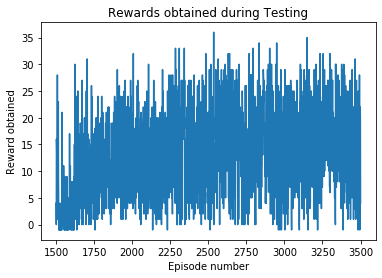

In [7]:
%matplotlib inline

plt.plot (list(range(1500,3501)), rewards)
plt.title("Rewards obtained during Testing")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.show()

In [20]:
print ("The maximum length obtained was ", max(rewards)+2)
# The maximum length is 36, plus the -1 when dying, plus the initial square
print ("The maximum percentage of squares covered was %.2f%%" % ((max(rewards)+2)/(9*9)*100))

The maximum length obtained was  38
The maximum percentage of squares covered was 46.91%
